<a href="https://colab.research.google.com/github/lgiesen/forest_height/blob/main/notebooks/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# the zipped data is uploaded in the root_path folder
root_path = 'drive/MyDrive/Colab Notebooks/data/'
path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'
user = "lgiesen"
repo = "forest_height"
!git clone https://github.com/{user}/{repo}.git

Cloning into 'forest_height'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 371 (delta 7), reused 10 (delta 1), pack-reused 348
Receiving objects: 100% (371/371), 20.53 MiB | 12.33 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [3]:
%run /content/forest_height/src/load_data.py
%run /content/forest_height/src/evaluate_model.py

Color Channels and NDVI

In [25]:
from sklearn.ensemble import RandomForestRegressor
X_train, y_train, X_test, y_test = load_data("color_channels_ndvi")
# initialize model
rf = RandomForestRegressor(random_state=42)
# train model
rf.fit(X_train, y_train)
# predict test set
y_pred = rf.predict(X_test)
mae_color_channels_ndvi, mse_color_channels_ndvi, rmse_color_channels_ndvi, mape_color_channels_ndvi = evaluate_model(y_test, y_pred)

MAE: 10.450072236026703; MSE: 152.5827937802089; RMSE: 12.352440802538133; MAPE: 1.3046686151539104


Feature Importance

Feature: 0, Score: 0.06925
Feature: 1, Score: 0.09639
Feature: 2, Score: 0.09280
Feature: 3, Score: 0.06651
Feature: 4, Score: 0.09093
Feature: 5, Score: 0.05885
Feature: 6, Score: 0.07522
Feature: 7, Score: 0.06545
Feature: 8, Score: 0.10803
Feature: 9, Score: 0.07313
Feature: 10, Score: 0.20344


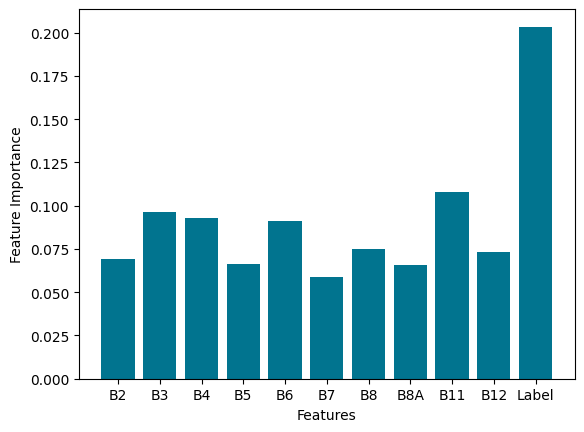

In [14]:
import matplotlib.pyplot as plt
# get importance
# importance = rf_random.coef_
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'Label'], importance, color="#01748F")
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.show()

RMSE: 12.252092643312652


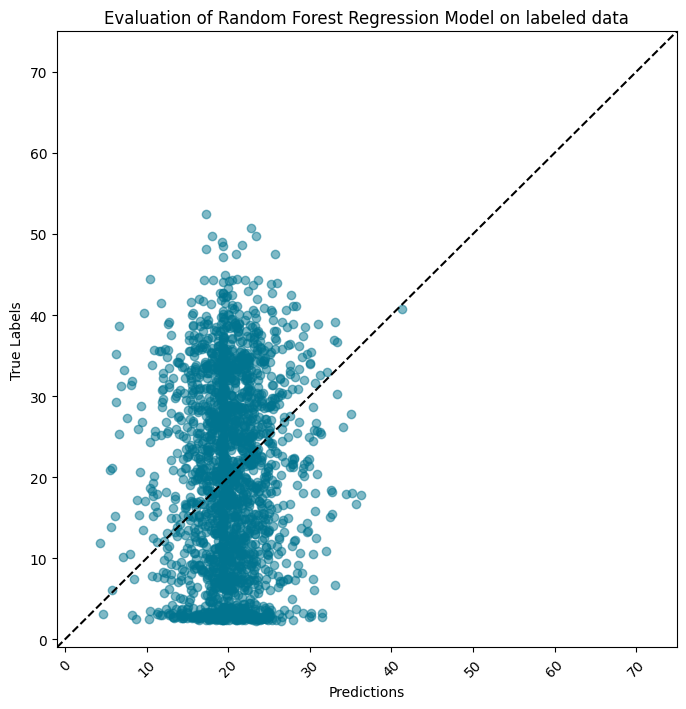

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from sklearn.metrics import mean_squared_error

# compute RMSE
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

# visualize predictions vs. true labels
fig = plt.figure(figsize=(8,8))
plt.scatter(y_pred, y_test, color="#01748F", alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.plot([-1,75], [-1, 75], 'k--')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.xlim([-1,75])
plt.ylim([-1,75])
plt.title("Evaluation of Random Forest Regression Model on labeled data")
plt.show()

Ndvi

In [18]:
X_train, y_train, X_test, y_test = load_data("ndvi")
#reshape
X_train, X_test = X_train.reshape(-1,1), X_test.reshape(-1,1)
# initialize model
rf_ndvi = RandomForestRegressor(random_state=42)
# train model
rf_ndvi.fit(X_train, y_train)
# predict test set
y_pred = rf_ndvi.predict(X_test)
mae_ndvi, mse_ndvi, rmse_ndvi, mape_ndvi = evaluate_model(y_test, y_pred)

MAE: 10.83361410394242; MSE: 165.3802201289557; RMSE: 12.860024110745504; MAPE: 1.288705239750867


Color channels

In [23]:
load_data("color_channels")
# initialize model
rf_color_channels = RandomForestRegressor(random_state=42)
# train model
rf_color_channels.fit(X_train, y_train)
# predict test set
y_pred = rf_color_channels.predict(X_test)
mae_color_channels, mse_color_channels, rmse_color_channels, mape_color_channels = evaluate_model(y_test, y_pred)

MAE: 10.83361410394242; MSE: 165.3802201289557; RMSE: 12.860024110745504; MAPE: 1.288705239750867


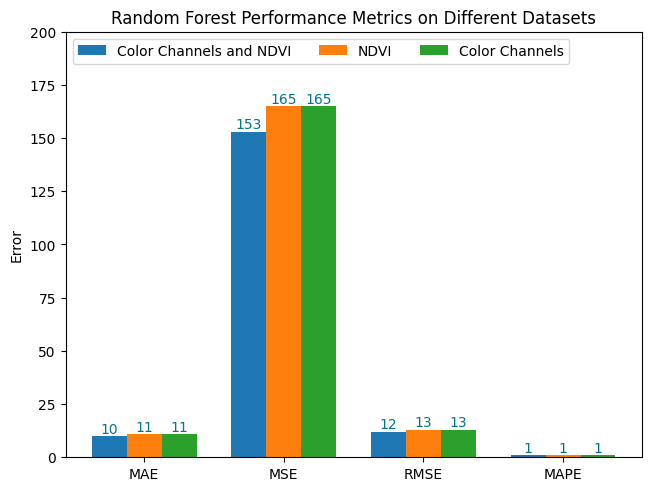

In [45]:
group = ("MAE", "MSE", "RMSE", "MAPE")
errors = {
    'Color Channels and NDVI': (mae_color_channels_ndvi, mse_color_channels_ndvi, rmse_color_channels_ndvi, mape_color_channels_ndvi),
    'NDVI': (mae_ndvi, mse_ndvi, rmse_ndvi, mape_ndvi),
    'Color Channels': (mae_color_channels, mse_color_channels, rmse_color_channels, mape_color_channels),
}

x = np.arange(len(group))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in errors.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement), width, label=attribute)
    ax.bar_label(rects, padding=0, color="#01748F")
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error')
ax.set_title('Random Forest Performance Metrics on Different Datasets')
ax.set_xticks(x + width, group)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 200)

plt.show()

Random Forest performs similarly on every dataset. It is worth noting that color channels and NDVI combined yield slightly better results than the rest.

Random Search

Try Random Search with only the ndvi values because the data is much smaller than the other datasets and it took a long time to perform.

In [47]:
X_train, y_train, X_test, y_test = load_data("ndvi")
#reshape
X_train, X_test = X_train.reshape(-1,1), X_test.reshape(-1,1)
# initialize model
rf_ndvi = RandomForestRegressor(random_state=42)
# train model
rf_ndvi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [56]:
import numpy as np
# Number of trees in random forest
n_estimators = [100, 300, 500] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': ['absolute_error'],
               'bootstrap': bootstrap}

In [57]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# initialize model
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    # scoring="neg_mean_absolute_error", # strategy to evaluate the performance
    n_iter=100,
    cv=3, # k-fold cross-validation
    verbose=2, # the higher, the more messages
    random_state=42,
    #n_jobs=-1, # use all processors
    return_train_score=True)

# train model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, criterion=absolute_error, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.2min
[CV] END bootstrap=False, criterion=absolute_error, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 4.4min
[CV] END bootstrap=False, criterion=absolute_error, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.7min
[CV] END bootstrap=True, criterion=absolute_error, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  20.4s
[CV] END bootstrap=True, criterion=absolute_error, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  23.7s
[CV] END bootstrap=True, criterion=absolute_error, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_spl

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['absolute_error'],
                                        'max_depth': [1, 25, 50, 75, 100],
                                        'max_features': ['log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, return_train_score=True, verbose=2)

In [58]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 1,
 'criterion': 'absolute_error',
 'bootstrap': True}

In [59]:
# predict test set
y_pred = rf_random.predict(X_test)
mae_ndvi, mse_ndvi, rmse_ndvi, mape_ndvi = evaluate_model(y_test, y_pred)

MAE: 10.021537493308648; MSE: 136.5169536595948; RMSE: 11.684046972671533; MAPE: 1.2434139977359764


In [62]:
import joblib
%cd forest_height/models
# save model
joblib.dump(rf_random, f'random_forest_{round(mae_ndvi,2)}.joblib')
# load model with:
%cd ../../
# rf = joblib.load(f"{models_path}random_forest_NDVI_10.02.joblib")

/content/forest_height/models
/content


# todo: feature importance on rf_random

As visualized in the bar graph, the NDVI channel value is the most significant one.

In [17]:
# rerun this cell
sort = rf.feature_importances_.argsort()
plt.bar(X_train.feature_names[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

KeyError: ignored

Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = random_grid,
    cv = 3,
    n_jobs = -1,
    verbose = 3)

In [ ]:
%%time
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
# initialize model
rf = RandomForestRegressor(rf_random.best_params_, random_state=42)

# train model
rf.fit(X_train, y_train)

Save model

In [ ]:
import joblib
# save model
joblib.dump(rf, 'random_forest.joblib')
# load model with:
# rf = joblib.load("random_forest.joblib")

In [ ]:
X_test = X_test.reshape(-1, 1)

In [ ]:
base_accuracy = evaluate(rf_random, X_test, y_test)

In [ ]:
y_pred = rf_random.predict(X_test)

Visualize prediction

In [ ]:
%run forest_height/src/visualize_data.py

In [ ]:
plot(y_pred[0])
plot(X_test[0])

In [ ]:
ypred_rf = rf.predict(Xtest)

mse_rf = mse(ytest, ypred_rf)
rmse_rf = mse_rf ** (1/2)
mae_rf = mae(ytest, ypred_rf)
mape_rf = mape(ytest, ypred_rf)

print(mape_rf)
print(mae_rf)
print(rmse_rf)

In [ ]:
mae, mse, rmse, mape = evaluate_model(y_test, y_pred)

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(X_test, y_test, color = 'green')
plt.scatter(X_test, y_pred, color = 'red')
plt.title('Random Forest Regression')
plt.xlabel('Pixel')
plt.ylabel('Forest Height')
plt.show()

In [ ]:
del X_train, y_train